Maximum stable dt: 0.0000191716
Using dt: 0.0000191679 with 4288 time steps
CFL ratio: 0.9998 (should be <= 1.0)
Grid setup complete: 501 spatial points, 4289 time points
S range: [70, 130], dS: 0.1200
T range: [0, 0.0822], dt: 0.0000191679

Terminal condition (payoff at expiration):
Min: -5.000000, Max: 0.000000
Sample values at S = 95, 100, 105: 0.000000, 0.000000, 0.000000

Tridiagonal matrix coefficients at middle of grid:
a[250]: 0.265821
b[250]: 1.532441
c[250]: 0.266620

At time step 4280, t = 0.082038:
Max difference from continuation value: 4.061753e-03
Number of roll points - Put: 34.0, Call: 38.0
Put wing roll boundary: S = 96.4000
Call wing roll boundary: S = 103.6000
Value at S = 100.00: -0.000000
Put wing value: -0.000000, Call wing value: -0.000000

At time step 3852, t = 0.073835:
Max difference from continuation value: 1.060137e-05
Number of roll points - Put: 3.0, Call: 4.0
Put wing roll boundary: S = 103.9600
Call wing roll boundary: S = 95.4400
Value at S = 100.00: 

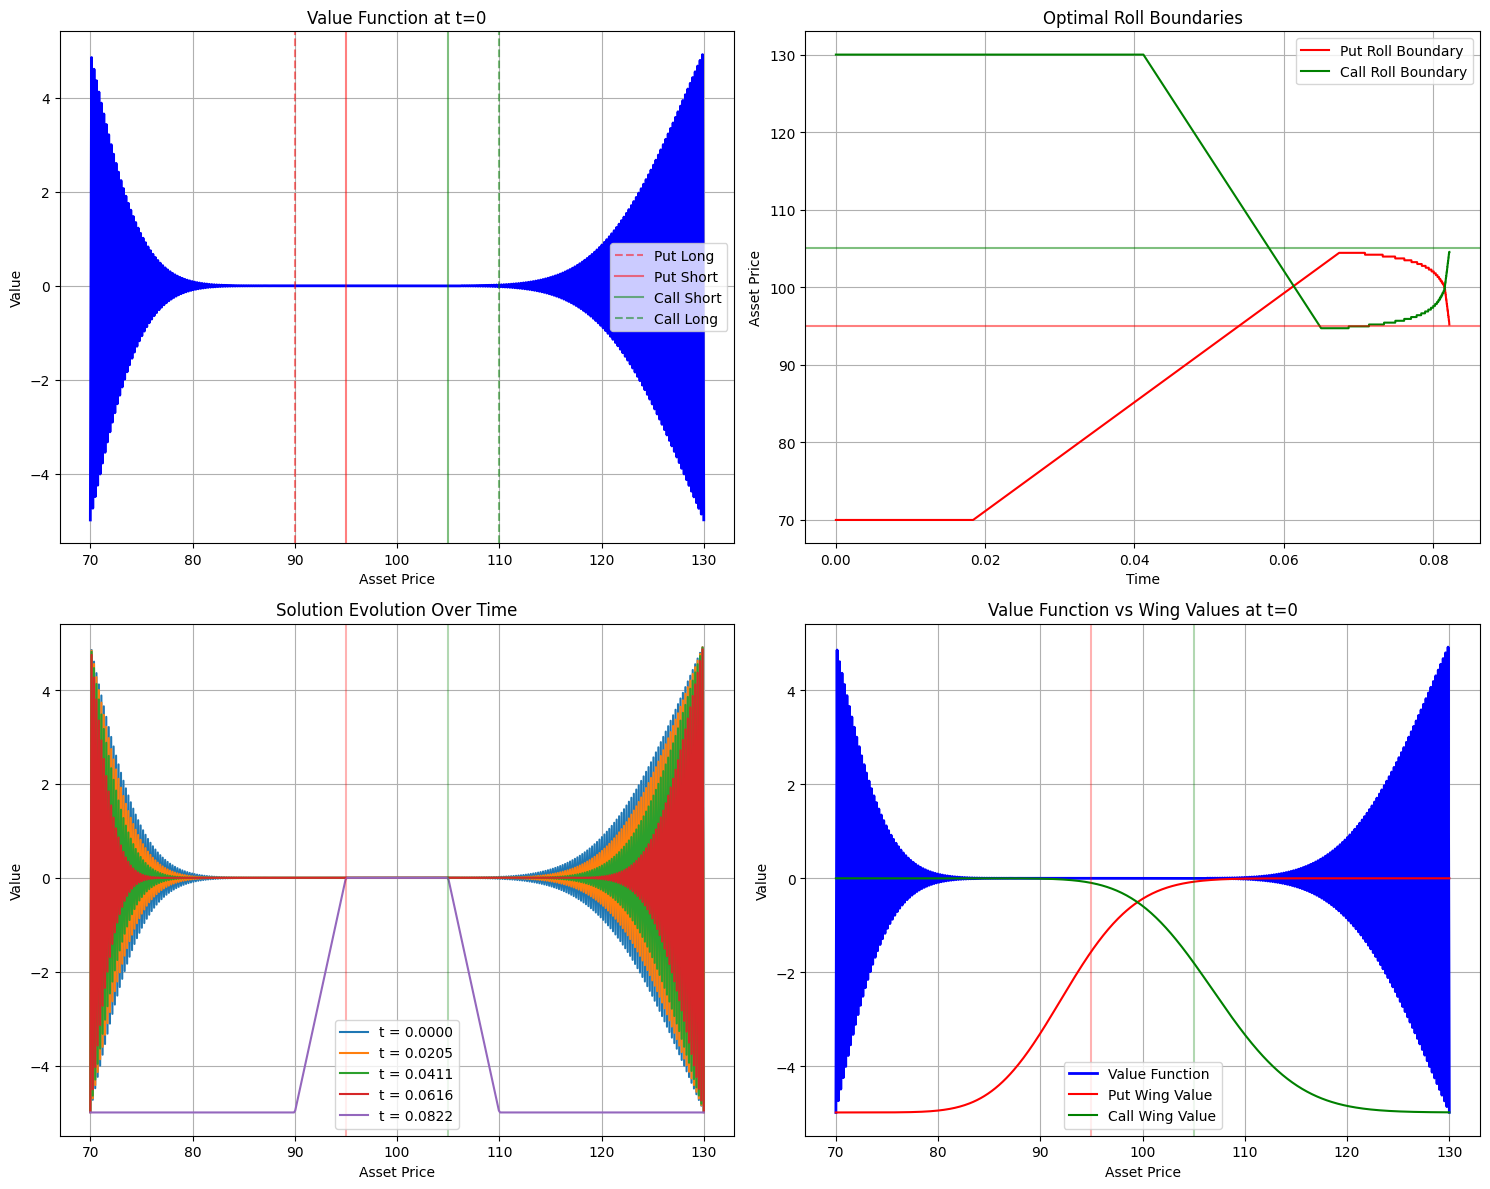

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import time

class IronCondorOptimalRoll:
    def __init__(self, S0, r, sigma, T, K_put_long, K_put_short, K_call_short, K_call_long):
        # Market parameters
        self.S0 = S0          # Initial underlying price
        self.r = r            # Risk-free rate
        self.sigma = sigma    # Volatility

        # Option parameters
        self.T = T            # Time to expiration
        self.K_put_long = K_put_long      # Long put strike
        self.K_put_short = K_put_short    # Short put strike
        self.K_call_short = K_call_short  # Short call strike
        self.K_call_long = K_call_long    # Long call strike

        # Grid parameters (to be set in setup_grid)
        self.S_min = None
        self.S_max = None
        self.Ns = None
        self.Nt = None
        self.dS = None
        self.dt = None
        self.S_grid = None
        self.t_grid = None

        # Solution arrays
        self.J = None         # Value function
        self.roll_boundary_put = None  # Optimal roll boundary for put wing
        self.roll_boundary_call = None  # Optimal roll boundary for call wing

    def setup_grid(self, S_min, S_max, Ns, Nt):
        """Set up the computational grid with stability check"""
        self.S_min = S_min
        self.S_max = S_max
        self.Ns = Ns
        self.Nt = Nt

        self.dS = (S_max - S_min) / Ns

        # Calculate maximum stable dt based on CFL condition
        dt_max = 0.9 * (self.dS**2) / (self.sigma**2 * self.S_max**2)
        print(f"Maximum stable dt: {dt_max:.10f}")

        # Set dt to be stable
        self.dt = min(self.T / Nt, dt_max)
        self.Nt = int(self.T / self.dt) + 1
        self.dt = self.T / self.Nt  # Recalculate dt for even spacing

        print(f"Using dt: {self.dt:.10f} with {self.Nt} time steps")
        print(f"CFL ratio: {self.dt/dt_max:.4f} (should be <= 1.0)")

        self.S_grid = np.linspace(S_min, S_max, Ns + 1)
        self.t_grid = np.linspace(0, self.T, self.Nt + 1)

        # Initialize solution arrays
        self.J = np.zeros((self.Nt + 1, Ns + 1))
        self.roll_boundary_put = np.full(self.Nt + 1, np.nan)
        self.roll_boundary_call = np.full(self.Nt + 1, np.nan)

        print(f"Grid setup complete: {Ns+1} spatial points, {self.Nt+1} time points")
        print(f"S range: [{S_min}, {S_max}], dS: {self.dS:.4f}")
        print(f"T range: [0, {self.T:.4f}], dt: {self.dt:.10f}")

    def black_scholes_call(self, S, K, t):
        """Calculate Black-Scholes call option price"""
        tau = self.T - t
        if tau <= 1e-10:
            return np.maximum(S - K, 0)

        d1 = (np.log(S / K) + (self.r + 0.5 * self.sigma**2) * tau) / (self.sigma * np.sqrt(tau))
        d2 = d1 - self.sigma * np.sqrt(tau)

        return S * norm.cdf(d1) - K * np.exp(-self.r * tau) * norm.cdf(d2)

    def black_scholes_put(self, S, K, t):
        """Calculate Black-Scholes put option price"""
        tau = self.T - t
        if tau <= 1e-10:
            return np.maximum(K - S, 0)

        d1 = (np.log(S / K) + (self.r + 0.5 * self.sigma**2) * tau) / (self.sigma * np.sqrt(tau))
        d2 = d1 - self.sigma * np.sqrt(tau)

        return K * np.exp(-self.r * tau) * norm.cdf(-d2) - S * norm.cdf(-d1)

    def iron_condor_value(self, S, t):
        """Calculate the value of the iron condor at a given asset price and time"""
        # Iron condor = long put + short put + short call + long call
        long_put = self.black_scholes_put(S, self.K_put_long, t)
        short_put = -self.black_scholes_put(S, self.K_put_short, t)
        short_call = -self.black_scholes_call(S, self.K_call_short, t)
        long_call = self.black_scholes_call(S, self.K_call_long, t)

        return long_put + short_put + short_call + long_call

    def determine_challenged_wing(self, S):
        """Determine which wing is challenged based on current asset price"""
        # Calculate relative distances to short strikes
        distance_to_put = (S - self.K_put_short) / self.K_put_short
        distance_to_call = (self.K_call_short - S) / self.K_call_short

        # The wing with smaller (or negative) distance is challenged
        if distance_to_put < distance_to_call:
            return "put"
        else:
            return "call"

    def challenged_wing_value(self, S, t, wing=None):
        """Calculate the value of the challenged wing"""
        if wing is None:
            wing = self.determine_challenged_wing(S)

        if wing == "call":
            # Call wing is challenged
            short_call = -self.black_scholes_call(S, self.K_call_short, t)
            long_call = self.black_scholes_call(S, self.K_call_long, t)
            return short_call + long_call
        else:
            # Put wing is challenged
            short_put = -self.black_scholes_put(S, self.K_put_short, t)
            long_put = self.black_scholes_put(S, self.K_put_long, t)
            return short_put + long_put

    def build_tridiagonal_matrix(self):
        """Build the tridiagonal matrix for the implicit scheme"""
        n = self.Ns

        # Initialize the tridiagonal matrix coefficients
        a = np.zeros(n+1)  # subdiagonal
        b = np.zeros(n+1)  # diagonal
        c = np.zeros(n+1)  # superdiagonal

        for i in range(1, n):
            S = self.S_grid[i]

            # Coefficients for the Black-Scholes operator
            alpha = 0.5 * self.sigma**2 * S**2 / self.dS**2
            beta = self.r * S / (2 * self.dS)

            a[i] = self.dt * (alpha - beta)
            b[i] = 1 + self.dt * (2 * alpha + self.r)
            c[i] = self.dt * (alpha + beta)

        # Boundary conditions
        a[0] = 0
        b[0] = 1
        c[0] = 0

        a[n] = 0
        b[n] = 1
        c[n] = 0

        return a, b, c

    def thomas_algorithm(self, a, b, c, d):
        """Solve a tridiagonal system using the Thomas algorithm"""
        n = len(d) - 1

        # Forward sweep
        c_prime = np.zeros(n+1)
        d_prime = np.zeros(n+1)

        c_prime[0] = c[0] / b[0]
        d_prime[0] = d[0] / b[0]

        for i in range(1, n+1):
            denominator = b[i] - a[i] * c_prime[i-1]
            if i < n:
                c_prime[i] = c[i] / denominator
            d_prime[i] = (d[i] - a[i] * d_prime[i-1]) / denominator

        # Back substitution
        x = np.zeros(n+1)
        x[n] = d_prime[n]

        for i in range(n-1, -1, -1):
            x[i] = d_prime[i] - c_prime[i] * x[i+1]

        return x

    def solve(self):
        """Solve the variational inequality using finite difference method with detailed diagnostics"""
        start_time = time.time()

        # Set terminal condition (at expiration)
        for i in range(self.Ns + 1):
            self.J[-1, i] = self.iron_condor_value(self.S_grid[i], self.T)

        # Print terminal condition for debugging
        print("\nTerminal condition (payoff at expiration):")
        print(f"Min: {np.min(self.J[-1, :]):.6f}, Max: {np.max(self.J[-1, :]):.6f}")
        print(f"Sample values at S = 95, 100, 105: {self.J[-1, self.Ns//2-10]:.6f}, {self.J[-1, self.Ns//2]:.6f}, {self.J[-1, self.Ns//2+10]:.6f}")

        # Build tridiagonal matrix
        a, b, c = self.build_tridiagonal_matrix()

        # Print matrix coefficients for a few points
        mid_idx = self.Ns // 2
        print("\nTridiagonal matrix coefficients at middle of grid:")
        print(f"a[{mid_idx}]: {a[mid_idx]:.6f}")
        print(f"b[{mid_idx}]: {b[mid_idx]:.6f}")
        print(f"c[{mid_idx}]: {c[mid_idx]:.6f}")

        # Diagnostic arrays to track solution evolution
        max_diff_per_step = np.zeros(self.Nt)
        num_roll_points_put = np.zeros(self.Nt)
        num_roll_points_call = np.zeros(self.Nt)

        # Solve backwards in time
        for n in range(self.Nt-1, -1, -1):
            t = self.t_grid[n]

            # Right-hand side of the linear system
            d = np.copy(self.J[n+1, :])

            # Apply boundary conditions
            d[0] = self.iron_condor_value(self.S_min, t)
            d[-1] = self.iron_condor_value(self.S_max, t)

            # Solve the linear system
            J_continuation = self.thomas_algorithm(a, b, c, d)

            # Initialize the solution for this time step
            self.J[n, :] = J_continuation

            # Calculate challenged wing values for all grid points
            put_wing_values = np.array([self.challenged_wing_value(S, t, "put") for S in self.S_grid])
            call_wing_values = np.array([self.challenged_wing_value(S, t, "call") for S in self.S_grid])

            # For each grid point, determine if rolling should be considered
            roll_put_indices = []
            roll_call_indices = []

            for i in range(self.Ns + 1):
                S = self.S_grid[i]

                # Check if put wing is challenged
                if S < self.K_put_short * 1.1:
                    if put_wing_values[i] > J_continuation[i]:
                        self.J[n, i] = put_wing_values[i]
                        roll_put_indices.append(i)

                # Check if call wing is challenged
                if S > self.K_call_short * 0.9:
                    if call_wing_values[i] > J_continuation[i]:
                        self.J[n, i] = call_wing_values[i]
                        roll_call_indices.append(i)

            # Record number of roll points
            num_roll_points_put[n] = len(roll_put_indices)
            num_roll_points_call[n] = len(roll_call_indices)

            # Find the roll boundaries
            if roll_put_indices:
                self.roll_boundary_put[n] = self.S_grid[min(roll_put_indices)]

            if roll_call_indices:
                self.roll_boundary_call[n] = self.S_grid[max(roll_call_indices)]

            # Calculate maximum difference for this time step
            max_diff_per_step[n] = np.max(np.abs(self.J[n, :] - J_continuation))

            # Print diagnostics at regular intervals
            if n % max(1, self.Nt // 10) == 0:
                print(f"\nAt time step {n}, t = {t:.6f}:")
                print(f"Max difference from continuation value: {max_diff_per_step[n]:.6e}")
                print(f"Number of roll points - Put: {num_roll_points_put[n]}, Call: {num_roll_points_call[n]}")

                if not np.isnan(self.roll_boundary_put[n]):
                    print(f"Put wing roll boundary: S = {self.roll_boundary_put[n]:.4f}")
                else:
                    print("No put wing roll boundary found")

                if not np.isnan(self.roll_boundary_call[n]):
                    print(f"Call wing roll boundary: S = {self.roll_boundary_call[n]:.4f}")
                else:
                    print("No call wing roll boundary found")

                mid_idx = self.Ns // 2
                print(f"Value at S = {self.S_grid[mid_idx]:.2f}: {self.J[n, mid_idx]:.6f}")
                print(f"Put wing value: {put_wing_values[mid_idx]:.6f}, Call wing value: {call_wing_values[mid_idx]:.6f}")

        end_time = time.time()
        print(f"\nSolution completed in {end_time - start_time:.2f} seconds")
        print(f"Maximum value difference across all time steps: {np.max(max_diff_per_step):.6e}")

        # Print final solution statistics
        print("\nFinal solution statistics:")
        print(f"Value function at t=0, S={self.S0}: {np.interp(self.S0, self.S_grid, self.J[0, :]):.6f}")

        if not np.isnan(self.roll_boundary_put[0]):
            print(f"Initial put wing roll boundary: S = {self.roll_boundary_put[0]:.4f}")
        else:
            print("No initial put wing roll boundary")

        if not np.isnan(self.roll_boundary_call[0]):
            print(f"Initial call wing roll boundary: S = {self.roll_boundary_call[0]:.4f}")
        else:
            print("No initial call wing roll boundary")

    def plot_results(self):
        """Plot the value function and roll boundaries with enhanced diagnostics"""
        plt.figure(figsize=(15, 12))

        # Plot the value function at t=0
        plt.subplot(2, 2, 1)
        plt.plot(self.S_grid, self.J[0, :], 'b-', linewidth=2)
        plt.axvline(x=self.K_put_long, color='r', linestyle='--', alpha=0.5, label='Put Long')
        plt.axvline(x=self.K_put_short, color='r', linestyle='-', alpha=0.5, label='Put Short')
        plt.axvline(x=self.K_call_short, color='g', linestyle='-', alpha=0.5, label='Call Short')
        plt.axvline(x=self.K_call_long, color='g', linestyle='--', alpha=0.5, label='Call Long')
        plt.xlabel('Asset Price')
        plt.ylabel('Value')
        plt.title('Value Function at t=0')
        plt.grid(True)
        plt.legend()

        # Plot the roll boundaries
        plt.subplot(2, 2, 2)
        valid_put = ~np.isnan(self.roll_boundary_put)
        valid_call = ~np.isnan(self.roll_boundary_call)

        if np.any(valid_put):
            plt.plot(self.t_grid[valid_put], self.roll_boundary_put[valid_put], 'r-', label='Put Roll Boundary')
        if np.any(valid_call):
            plt.plot(self.t_grid[valid_call], self.roll_boundary_call[valid_call], 'g-', label='Call Roll Boundary')

        plt.axhline(y=self.K_put_short, color='r', linestyle='-', alpha=0.5)
        plt.axhline(y=self.K_call_short, color='g', linestyle='-', alpha=0.5)
        plt.xlabel('Time')
        plt.ylabel('Asset Price')
        plt.title('Optimal Roll Boundaries')
        plt.grid(True)
        plt.legend()

        # Plot the solution at different time steps
        plt.subplot(2, 2, 3)
        time_indices = [0, self.Nt//4, self.Nt//2, 3*self.Nt//4, self.Nt]
        for idx in time_indices:
            if idx < len(self.t_grid):
                plt.plot(self.S_grid, self.J[idx, :],
                         label=f't = {self.t_grid[idx]:.4f}')
        plt.axvline(x=self.K_put_short, color='r', linestyle='-', alpha=0.3)
        plt.axvline(x=self.K_call_short, color='g', linestyle='-', alpha=0.3)
        plt.xlabel('Asset Price')
        plt.ylabel('Value')
        plt.title('Solution Evolution Over Time')
        plt.grid(True)
        plt.legend()

        # Plot the challenged wing values vs continuation value
        plt.subplot(2, 2, 4)
        t0_idx = 0  # Index for t=0
        put_wing_values = np.array([self.challenged_wing_value(S, self.t_grid[t0_idx], "put") for S in self.S_grid])
        call_wing_values = np.array([self.challenged_wing_value(S, self.t_grid[t0_idx], "call") for S in self.S_grid])

        plt.plot(self.S_grid, self.J[t0_idx, :], 'b-', label='Value Function', linewidth=2)
        plt.plot(self.S_grid, put_wing_values, 'r-', label='Put Wing Value', linewidth=1.5)
        plt.plot(self.S_grid, call_wing_values, 'g-', label='Call Wing Value', linewidth=1.5)

        plt.axvline(x=self.K_put_short, color='r', linestyle='-', alpha=0.3)
        plt.axvline(x=self.K_call_short, color='g', linestyle='-', alpha=0.3)
        plt.xlabel('Asset Price')
        plt.ylabel('Value')
        plt.title('Value Function vs Wing Values at t=0')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

def plot_value_surface(self):
    """Plot the 3D surface of the value function"""
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    X, Y = np.meshgrid(self.S_grid, self.t_grid)

    surf = ax.plot_surface(X, Y, self.J, cmap='viridis',
                          linewidth=0, antialiased=True)

    ax.set_xlabel('Asset Price')
    ax.set_ylabel('Time')
    ax.set_zlabel('Value')
    ax.set_title('Value Function Surface')

    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

# Example usage
if __name__ == "__main__":
    # Parameters
    S0 = 100          # Initial stock price
    r = 0.05          # Risk-free rate
    sigma = 0.2       # Volatility
    T = 30/365        # Time to expiration (30 days)

    # Iron condor strikes
    K_put_long = 90
    K_put_short = 95
    K_call_short = 105
    K_call_long = 110

    # Create solver
    solver = IronCondorOptimalRoll(S0, r, sigma, T, K_put_long, K_put_short, K_call_short, K_call_long)

    # Setup grid
    S_min = 70
    S_max = 130
    Ns = 500  # Increased for better resolution
    Nt = 200  # Increased for better stability
    solver.setup_grid(S_min, S_max, Ns, Nt)

    # Solve
    solver.solve()

    # Plot results
    solver.plot_results()

    # Optionally plot the 3D value surface
    # solver.plot_value_surface()



Maximum stable dt: 0.0000029752
Using dt: 0.0000029752 with 27626 time steps
CFL ratio: 1.0000 (should be <= 1.0)
Grid setup complete: 501 spatial points, 27627 time points
S range: [90, 110], dS: 0.0400
T range: [0, 0.0822], dt: 0.0000029752

Terminal condition (payoff at expiration):
Min: -5.000000, Max: 0.000000
Sample values at S = 95, 100, 105: 0.000000, 0.000000, 0.000000

Tridiagonal matrix coefficients at middle of grid:
a[250]: 0.371709
b[250]: 1.743790
c[250]: 0.372081

At time step 27620, t = 0.082174:
Max difference from continuation value: 4.876506e-03
Number of roll points - Put: 114.0, Call: 127.0
Put wing roll boundary: S = 95.4400
Call wing roll boundary: S = 104.6400
Value at S = 100.00: 0.000000
Put wing value: 0.000000, Call wing value: 0.000000

At time step 24858, t = 0.073957:
Max difference from continuation value: 1.185794e-03
Number of roll points - Put: 7.0, Call: 7.0
Put wing roll boundary: S = 104.0000
Call wing roll boundary: S = 95.0400
Value at S = 100.0

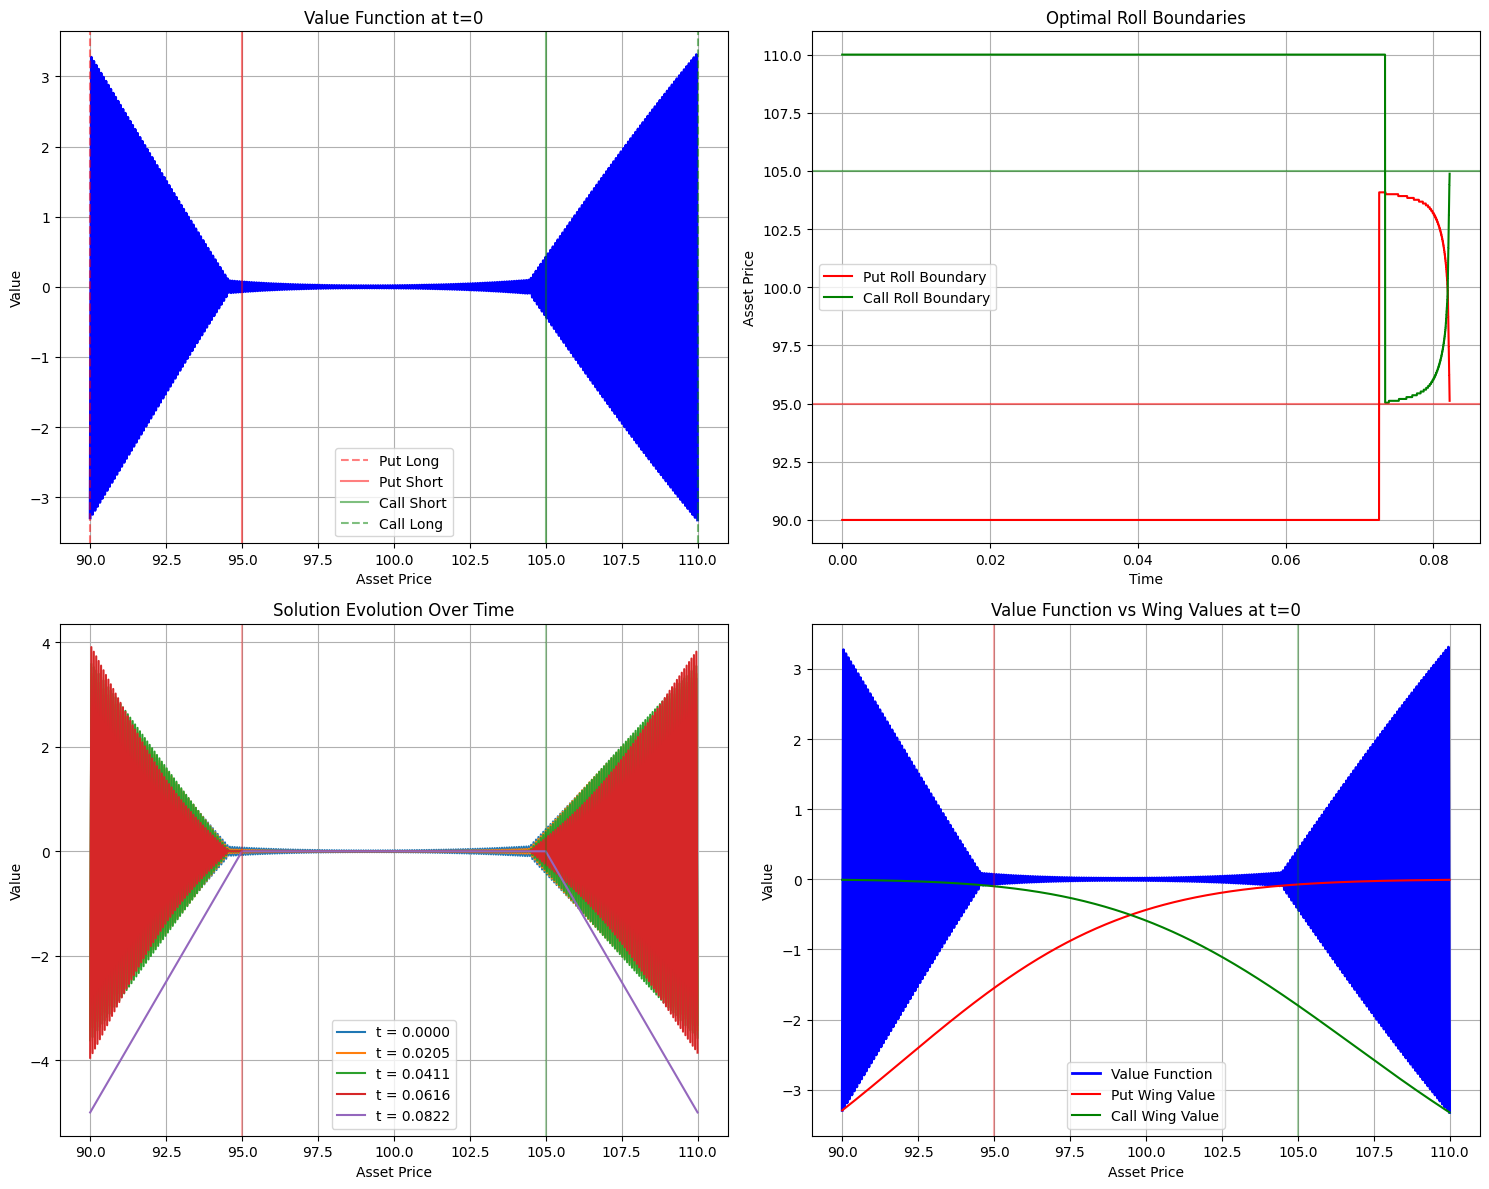

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import time

class IronCondorOptimalRoll:
    def __init__(self, S0, r, sigma, T, K_put_long, K_put_short, K_call_short, K_call_long):
        # Market parameters
        self.S0 = S0          # Initial underlying price
        self.r = r            # Risk-free rate
        self.sigma = sigma    # Volatility

        # Option parameters
        self.T = T            # Time to expiration
        self.K_put_long = K_put_long      # Long put strike
        self.K_put_short = K_put_short    # Short put strike
        self.K_call_short = K_call_short  # Short call strike
        self.K_call_long = K_call_long    # Long call strike

        # Grid parameters (to be set in setup_grid)
        self.S_min = None
        self.S_max = None
        self.Ns = None
        self.Nt = None
        self.dS = None
        self.dt = None
        self.S_grid = None
        self.t_grid = None

        # Solution arrays
        self.J = None         # Value function
        self.roll_boundary_put = None  # Optimal roll boundary for put wing
        self.roll_boundary_call = None  # Optimal roll boundary for call wing

    def setup_grid(self, S_min, S_max, Ns, Nt):
        """Set up the computational grid with stability check"""
        self.S_min = S_min
        self.S_max = S_max
        self.Ns = Ns
        self.Nt = Nt

        self.dS = (S_max - S_min) / Ns

        # Calculate maximum stable dt based on CFL condition
        dt_max = 0.9 * (self.dS**2) / (self.sigma**2 * self.S_max**2)
        print(f"Maximum stable dt: {dt_max:.10f}")

        # Set dt to be stable
        self.dt = min(self.T / Nt, dt_max)
        self.Nt = int(self.T / self.dt) + 1
        self.dt = self.T / self.Nt  # Recalculate dt for even spacing

        print(f"Using dt: {self.dt:.10f} with {self.Nt} time steps")
        print(f"CFL ratio: {self.dt/dt_max:.4f} (should be <= 1.0)")

        self.S_grid = np.linspace(S_min, S_max, Ns + 1)
        self.t_grid = np.linspace(0, self.T, self.Nt + 1)

        # Initialize solution arrays
        self.J = np.zeros((self.Nt + 1, Ns + 1))
        self.roll_boundary_put = np.full(self.Nt + 1, np.nan)
        self.roll_boundary_call = np.full(self.Nt + 1, np.nan)

        print(f"Grid setup complete: {Ns+1} spatial points, {self.Nt+1} time points")
        print(f"S range: [{S_min}, {S_max}], dS: {self.dS:.4f}")
        print(f"T range: [0, {self.T:.4f}], dt: {self.dt:.10f}")

    def black_scholes_call(self, S, K, t):
        """Calculate Black-Scholes call option price"""
        tau = self.T - t
        if tau <= 1e-10:
            return np.maximum(S - K, 0)

        d1 = (np.log(S / K) + (self.r + 0.5 * self.sigma**2) * tau) / (self.sigma * np.sqrt(tau))
        d2 = d1 - self.sigma * np.sqrt(tau)

        return S * norm.cdf(d1) - K * np.exp(-self.r * tau) * norm.cdf(d2)

    def black_scholes_put(self, S, K, t):
        """Calculate Black-Scholes put option price"""
        tau = self.T - t
        if tau <= 1e-10:
            return np.maximum(K - S, 0)

        d1 = (np.log(S / K) + (self.r + 0.5 * self.sigma**2) * tau) / (self.sigma * np.sqrt(tau))
        d2 = d1 - self.sigma * np.sqrt(tau)

        return K * np.exp(-self.r * tau) * norm.cdf(-d2) - S * norm.cdf(-d1)

    def iron_condor_value(self, S, t):
        """Calculate the value of the iron condor at a given asset price and time"""
        # Iron condor = long put + short put + short call + long call
        long_put = self.black_scholes_put(S, self.K_put_long, t)
        short_put = -self.black_scholes_put(S, self.K_put_short, t)
        short_call = -self.black_scholes_call(S, self.K_call_short, t)
        long_call = self.black_scholes_call(S, self.K_call_long, t)

        return long_put + short_put + short_call + long_call

    def determine_challenged_wing(self, S):
        """Determine which wing is challenged based on current asset price"""
        # Calculate relative distances to short strikes
        distance_to_put = (S - self.K_put_short) / self.K_put_short
        distance_to_call = (self.K_call_short - S) / self.K_call_short

        # The wing with smaller (or negative) distance is challenged
        if distance_to_put < distance_to_call:
            return "put"
        else:
            return "call"

    def challenged_wing_value(self, S, t, wing=None):
        """Calculate the value of the challenged wing"""
        if wing is None:
            wing = self.determine_challenged_wing(S)

        if wing == "call":
            # Call wing is challenged
            short_call = -self.black_scholes_call(S, self.K_call_short, t)
            long_call = self.black_scholes_call(S, self.K_call_long, t)
            return short_call + long_call
        else:
            # Put wing is challenged
            short_put = -self.black_scholes_put(S, self.K_put_short, t)
            long_put = self.black_scholes_put(S, self.K_put_long, t)
            return short_put + long_put

    def build_tridiagonal_matrix(self):
        """Build the tridiagonal matrix for the implicit scheme"""
        n = self.Ns

        # Initialize the tridiagonal matrix coefficients
        a = np.zeros(n+1)  # subdiagonal
        b = np.zeros(n+1)  # diagonal
        c = np.zeros(n+1)  # superdiagonal

        for i in range(1, n):
            S = self.S_grid[i]

            # Coefficients for the Black-Scholes operator
            alpha = 0.5 * self.sigma**2 * S**2 / self.dS**2
            beta = self.r * S / (2 * self.dS)

            a[i] = self.dt * (alpha - beta)
            b[i] = 1 + self.dt * (2 * alpha + self.r)
            c[i] = self.dt * (alpha + beta)

        # Boundary conditions
        a[0] = 0
        b[0] = 1
        c[0] = 0

        a[n] = 0
        b[n] = 1
        c[n] = 0

        return a, b, c

    def thomas_algorithm(self, a, b, c, d):
        """Solve a tridiagonal system using the Thomas algorithm"""
        n = len(d) - 1

        # Forward sweep
        c_prime = np.zeros(n+1)
        d_prime = np.zeros(n+1)

        c_prime[0] = c[0] / b[0]
        d_prime[0] = d[0] / b[0]

        for i in range(1, n+1):
            denominator = b[i] - a[i] * c_prime[i-1]
            if i < n:
                c_prime[i] = c[i] / denominator
            d_prime[i] = (d[i] - a[i] * d_prime[i-1]) / denominator

        # Back substitution
        x = np.zeros(n+1)
        x[n] = d_prime[n]

        for i in range(n-1, -1, -1):
            x[i] = d_prime[i] - c_prime[i] * x[i+1]

        return x

    def solve(self):
        """Solve the variational inequality using finite difference method with detailed diagnostics"""
        start_time = time.time()

        # Set terminal condition (at expiration)
        for i in range(self.Ns + 1):
            self.J[-1, i] = self.iron_condor_value(self.S_grid[i], self.T)

        # Print terminal condition for debugging
        print("\nTerminal condition (payoff at expiration):")
        print(f"Min: {np.min(self.J[-1, :]):.6f}, Max: {np.max(self.J[-1, :]):.6f}")
        print(f"Sample values at S = 95, 100, 105: {self.J[-1, self.Ns//2-10]:.6f}, {self.J[-1, self.Ns//2]:.6f}, {self.J[-1, self.Ns//2+10]:.6f}")

        # Build tridiagonal matrix
        a, b, c = self.build_tridiagonal_matrix()

        # Print matrix coefficients for a few points
        mid_idx = self.Ns // 2
        print("\nTridiagonal matrix coefficients at middle of grid:")
        print(f"a[{mid_idx}]: {a[mid_idx]:.6f}")
        print(f"b[{mid_idx}]: {b[mid_idx]:.6f}")
        print(f"c[{mid_idx}]: {c[mid_idx]:.6f}")

        # Diagnostic arrays to track solution evolution
        max_diff_per_step = np.zeros(self.Nt)
        num_roll_points_put = np.zeros(self.Nt)
        num_roll_points_call = np.zeros(self.Nt)

        # Solve backwards in time
        for n in range(self.Nt-1, -1, -1):
            t = self.t_grid[n]

            # Right-hand side of the linear system
            d = np.copy(self.J[n+1, :])

            # Apply boundary conditions
            d[0] = self.iron_condor_value(self.S_min, t)
            d[-1] = self.iron_condor_value(self.S_max, t)

            # Solve the linear system
            J_continuation = self.thomas_algorithm(a, b, c, d)

            # Initialize the solution for this time step
            self.J[n, :] = J_continuation

            # Calculate challenged wing values for all grid points
            put_wing_values = np.array([self.challenged_wing_value(S, t, "put") for S in self.S_grid])
            call_wing_values = np.array([self.challenged_wing_value(S, t, "call") for S in self.S_grid])

            # For each grid point, determine if rolling should be considered
            roll_put_indices = []
            roll_call_indices = []

            for i in range(self.Ns + 1):
                S = self.S_grid[i]

                # Check if put wing is challenged
                if S < self.K_put_short * 1.1:
                    if put_wing_values[i] > J_continuation[i]:
                        self.J[n, i] = put_wing_values[i]
                        roll_put_indices.append(i)

                # Check if call wing is challenged
                if S > self.K_call_short * 0.9:
                    if call_wing_values[i] > J_continuation[i]:
                        self.J[n, i] = call_wing_values[i]
                        roll_call_indices.append(i)

            # Record number of roll points
            num_roll_points_put[n] = len(roll_put_indices)
            num_roll_points_call[n] = len(roll_call_indices)

            # Find the roll boundaries
            if roll_put_indices:
                self.roll_boundary_put[n] = self.S_grid[min(roll_put_indices)]

            if roll_call_indices:
                self.roll_boundary_call[n] = self.S_grid[max(roll_call_indices)]

            # Calculate maximum difference for this time step
            max_diff_per_step[n] = np.max(np.abs(self.J[n, :] - J_continuation))

            # Print diagnostics at regular intervals
            if n % max(1, self.Nt // 10) == 0:
                print(f"\nAt time step {n}, t = {t:.6f}:")
                print(f"Max difference from continuation value: {max_diff_per_step[n]:.6e}")
                print(f"Number of roll points - Put: {num_roll_points_put[n]}, Call: {num_roll_points_call[n]}")

                if not np.isnan(self.roll_boundary_put[n]):
                    print(f"Put wing roll boundary: S = {self.roll_boundary_put[n]:.4f}")
                else:
                    print("No put wing roll boundary found")

                if not np.isnan(self.roll_boundary_call[n]):
                    print(f"Call wing roll boundary: S = {self.roll_boundary_call[n]:.4f}")
                else:
                    print("No call wing roll boundary found")

                mid_idx = self.Ns // 2
                print(f"Value at S = {self.S_grid[mid_idx]:.2f}: {self.J[n, mid_idx]:.6f}")
                print(f"Put wing value: {put_wing_values[mid_idx]:.6f}, Call wing value: {call_wing_values[mid_idx]:.6f}")

        end_time = time.time()
        print(f"\nSolution completed in {end_time - start_time:.2f} seconds")
        print(f"Maximum value difference across all time steps: {np.max(max_diff_per_step):.6e}")

        # Print final solution statistics
        print("\nFinal solution statistics:")
        print(f"Value function at t=0, S={self.S0}: {np.interp(self.S0, self.S_grid, self.J[0, :]):.6f}")

        if not np.isnan(self.roll_boundary_put[0]):
            print(f"Initial put wing roll boundary: S = {self.roll_boundary_put[0]:.4f}")
        else:
            print("No initial put wing roll boundary")

        if not np.isnan(self.roll_boundary_call[0]):
            print(f"Initial call wing roll boundary: S = {self.roll_boundary_call[0]:.4f}")
        else:
            print("No initial call wing roll boundary")

    def plot_results(self):
        """Plot the value function and roll boundaries with enhanced diagnostics"""
        plt.figure(figsize=(15, 12))

        # Plot the value function at t=0
        plt.subplot(2, 2, 1)
        plt.plot(self.S_grid, self.J[0, :], 'b-', linewidth=2)
        plt.axvline(x=self.K_put_long, color='r', linestyle='--', alpha=0.5, label='Put Long')
        plt.axvline(x=self.K_put_short, color='r', linestyle='-', alpha=0.5, label='Put Short')
        plt.axvline(x=self.K_call_short, color='g', linestyle='-', alpha=0.5, label='Call Short')
        plt.axvline(x=self.K_call_long, color='g', linestyle='--', alpha=0.5, label='Call Long')
        plt.xlabel('Asset Price')
        plt.ylabel('Value')
        plt.title('Value Function at t=0')
        plt.grid(True)
        plt.legend()

        # Plot the roll boundaries
        plt.subplot(2, 2, 2)
        valid_put = ~np.isnan(self.roll_boundary_put)
        valid_call = ~np.isnan(self.roll_boundary_call)

        if np.any(valid_put):
            plt.plot(self.t_grid[valid_put], self.roll_boundary_put[valid_put], 'r-', label='Put Roll Boundary')
        if np.any(valid_call):
            plt.plot(self.t_grid[valid_call], self.roll_boundary_call[valid_call], 'g-', label='Call Roll Boundary')

        plt.axhline(y=self.K_put_short, color='r', linestyle='-', alpha=0.5)
        plt.axhline(y=self.K_call_short, color='g', linestyle='-', alpha=0.5)
        plt.xlabel('Time')
        plt.ylabel('Asset Price')
        plt.title('Optimal Roll Boundaries')
        plt.grid(True)
        plt.legend()

        # Plot the solution at different time steps
        plt.subplot(2, 2, 3)
        time_indices = [0, self.Nt//4, self.Nt//2, 3*self.Nt//4, self.Nt]
        for idx in time_indices:
            if idx < len(self.t_grid):
                plt.plot(self.S_grid, self.J[idx, :],
                         label=f't = {self.t_grid[idx]:.4f}')
        plt.axvline(x=self.K_put_short, color='r', linestyle='-', alpha=0.3)
        plt.axvline(x=self.K_call_short, color='g', linestyle='-', alpha=0.3)
        plt.xlabel('Asset Price')
        plt.ylabel('Value')
        plt.title('Solution Evolution Over Time')
        plt.grid(True)
        plt.legend()

        # Plot the challenged wing values vs continuation value
        plt.subplot(2, 2, 4)
        t0_idx = 0  # Index for t=0
        put_wing_values = np.array([self.challenged_wing_value(S, self.t_grid[t0_idx], "put") for S in self.S_grid])
        call_wing_values = np.array([self.challenged_wing_value(S, self.t_grid[t0_idx], "call") for S in self.S_grid])

        plt.plot(self.S_grid, self.J[t0_idx, :], 'b-', label='Value Function', linewidth=2)
        plt.plot(self.S_grid, put_wing_values, 'r-', label='Put Wing Value', linewidth=1.5)
        plt.plot(self.S_grid, call_wing_values, 'g-', label='Call Wing Value', linewidth=1.5)

        plt.axvline(x=self.K_put_short, color='r', linestyle='-', alpha=0.3)
        plt.axvline(x=self.K_call_short, color='g', linestyle='-', alpha=0.3)
        plt.xlabel('Asset Price')
        plt.ylabel('Value')
        plt.title('Value Function vs Wing Values at t=0')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

def plot_value_surface(self):
    """Plot the 3D surface of the value function"""
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    X, Y = np.meshgrid(self.S_grid, self.t_grid)

    surf = ax.plot_surface(X, Y, self.J, cmap='viridis',
                          linewidth=0, antialiased=True)

    ax.set_xlabel('Asset Price')
    ax.set_ylabel('Time')
    ax.set_zlabel('Value')
    ax.set_title('Value Function Surface')

    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

# Example usage
if __name__ == "__main__":
    # Parameters
    S0 = 100          # Initial stock price
    r = 0.05          # Risk-free rate
    sigma = 0.2       # Volatility
    T = 30/365        # Time to expiration (30 days)

    # Iron condor strikes
    K_put_long = 90
    K_put_short = 95
    K_call_short = 105
    K_call_long = 110

    # Create solver
    solver = IronCondorOptimalRoll(S0, r, sigma, T, K_put_long, K_put_short, K_call_short, K_call_long)

    # Setup grid
    S_min = 90
    S_max = 110
    Ns = 500  # Increased for better resolution
    Nt = 200  # Increased for better stability
    solver.setup_grid(S_min, S_max, Ns, Nt)

    # Solve
    solver.solve()

    # Plot results
    solver.plot_results()

    # Optionally plot the 3D value surface
    # solver.plot_value_surface()

